In [1]:
# ── Cell 1: Environment Setup ─────────────────────────────────────────────
# Core libraries, plotting defaults, and pathlib for file paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

# ── Cell 2: Load Scaled Data & Define Pillars ────────────────────────────
scaled   = pd.read_csv("./data/clean/country_scaled_master.csv") \
                     .set_index("iso3")

# Define which columns belong to each pillar
demo_cols = [
    "total_population", "population_density", "urbanization_rate",
    "population_growth_pct", "literacy_rate_unesco", "life_expectancy"
]
econ_cols = [
    "gdp_total_usd", "gdp_per_capita_ppp", "real_gdp_growth_pct",
    "inflation_pct_wb", "unemployment_rate"
]
inf_cols  = [
    "military_expenditure_pct_gdp", "military_expenditure_constusd",
    "wgi_gov_effectiveness", "Corruption_Perception_Index_2024_iso3"
]
pillars = {"demo": demo_cols, "econ": econ_cols, "inf": inf_cols}

# Quick check
print("Scaled shape:", scaled.shape)
scaled[demo_cols + econ_cols + inf_cols].head()


Scaled shape: (216, 15)


,total_population,population_density,urbanization_rate,population_growth_pct,literacy_rate_unesco,life_expectancy,gdp_total_usd,gdp_per_capita_ppp,real_gdp_growth_pct,inflation_pct_wb,unemployment_rate,military_expenditure_pct_gdp,military_expenditure_constusd,wgi_gov_effectiveness,Corruption_Perception_Index_2024_iso3
iso3,,,,,,,,,,,,,,,
ABW,-0.261247,0.215131,-0.778503,-0.662445,0.258070,0.366177,-0.210813,0.591375,0.168432,0.207065,0.267264,-0.157777,-0.068199,0.859490,-0.167412
AFG,0.029669,-0.170590,-1.516730,0.655824,-4.204595,-1.085282,-0.204922,-0.954507,-0.078278,0.705741,-1.322919,-0.157777,-0.068199,-2.011716,-1.364108
AGO,-0.003434,-0.194885,0.262881,1.251938,-1.340074,-1.284755,-0.175612,-0.743739,-0.349894,-1.044938,-1.551597,-0.245827,-0.068199,-1.002414,-0.583654
ALB,-0.242682,-0.142301,0.088777,-1.415625,0.771903,0.823222,-0.202184,-0.265669,0.116464,0.262783,-0.727261,-0.092178,-0.068199,0.297534,-0.063352
AND,-0.261434,-0.093027,1.076332,0.213121,0.258070,1.447667,-0.210753,1.559026,-0.098508,0.207065,0.267264,-0.157777,-0.068199,1.561178,-0.167412


In [2]:
# ── Cell 3: Recompute Pillar-Level PCA Outputs ───────────────────────────
from sklearn.decomposition import PCA

# how many PCs you retained per pillar
n_demo, n_econ, n_inf = 4, 4, 3

# Demographic
pca_demo = PCA(n_components=n_demo, random_state=42)
demo_df  = pd.DataFrame(
    pca_demo.fit_transform(scaled[demo_cols]),
    columns=[f"demo_pc{i+1}" for i in range(n_demo)],
    index=scaled.index
)

# Economic
pca_econ = PCA(n_components=n_econ, random_state=42)
econ_df  = pd.DataFrame(
    pca_econ.fit_transform(scaled[econ_cols]),
    columns=[f"econ_pc{i+1}" for i in range(n_econ)],
    index=scaled.index
)

# Influence
pca_inf  = PCA(n_components=n_inf, random_state=42)
inf_df   = pd.DataFrame(
    pca_inf.fit_transform(scaled[inf_cols]),
    columns=[f"inf_pc{i+1}" for i in range(n_inf)],
    index=scaled.index
)

# Optional: verify
print("Demo PCs:", demo_df.shape, 
      "Econ PCs:", econ_df.shape,
      "Inf  PCs:", inf_df.shape)


Demo PCs: (216, 4) Econ PCs: (216, 4) Inf  PCs: (216, 3)


In [3]:
# ------------------------------------------------------------------
# 1. Stack all retained PCs into one wide table (already standardized)
# ------------------------------------------------------------------
X_pca = pd.concat(
    [demo_df.add_prefix("demo_"),
     econ_df.add_prefix("econ_"),
     inf_df.add_prefix("inf_")],
    axis=1
)

print(f"Feature matrix shape: {X_pca.shape}")  # e.g., (216 countries, 10 PCs)

Feature matrix shape: (216, 11)


c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

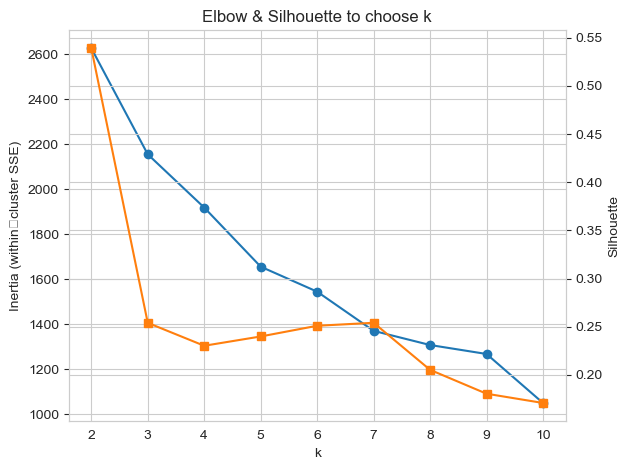

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

K = range(2, 11)
inertias, sils = [], []

for k in K:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_pca, labels))

fig, ax1 = plt.subplots()
ax1.plot(K, inertias, "-o")
ax1.set_xlabel("k")
ax1.set_ylabel("Inertia (within‑cluster SSE)")

ax2 = ax1.twinx()
ax2.plot(K, sils, "-s", color="C1")
ax2.set_ylabel("Silhouette")
plt.title("Elbow & Silhouette to choose k"); plt.tight_layout()
plt.show()


In [5]:
pillar_scores = pd.read_csv("./data/clean/pillar_scores_and_composite.csv")

best_k = 6               # <-- pick from Step 2
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_pca)

cluster_df = pd.DataFrame({
    "iso3": X_pca.index,
    "cluster": labels
})
cluster_df.to_csv("./data/clean/country_clusters_k6.csv", index=False)

# Add labels back to the pillar score table
pillar_scores["cluster"] = labels


c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster centroids in pillar space:
          demo_wsum  econ_wsum  inf_wsum
cluster                                
0             0.08       3.47     -0.05
1            -0.68      -0.12     -0.45
2             0.72       0.16      0.72
3             0.04      -0.04     -0.01
4             0.67       0.42      0.39
5            -0.10      -0.33     -0.51


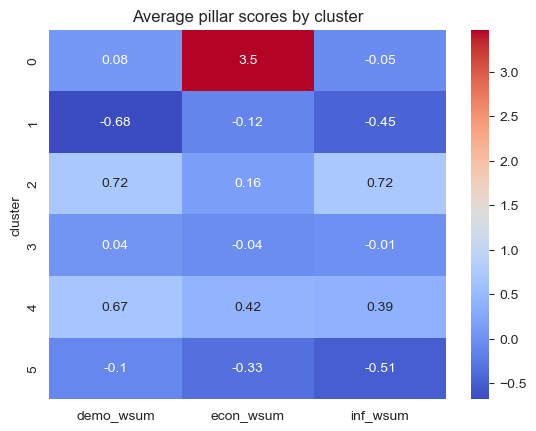

In [6]:
cluster_summary = pillar_scores.groupby("cluster")[
    ["demo_wsum", "econ_wsum", "inf_wsum"]
].mean().round(2)

print("Cluster centroids in pillar space:\n", cluster_summary)

import seaborn as sns
sns.heatmap(cluster_summary, annot=True, cmap="coolwarm")
plt.title("Average pillar scores by cluster"); plt.show()


C:\Users\caded\AppData\Local\Temp\ipykernel_424\2146365367.py:11: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.legend(title="Cluster"); plt.tight_layout(); plt.show()
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


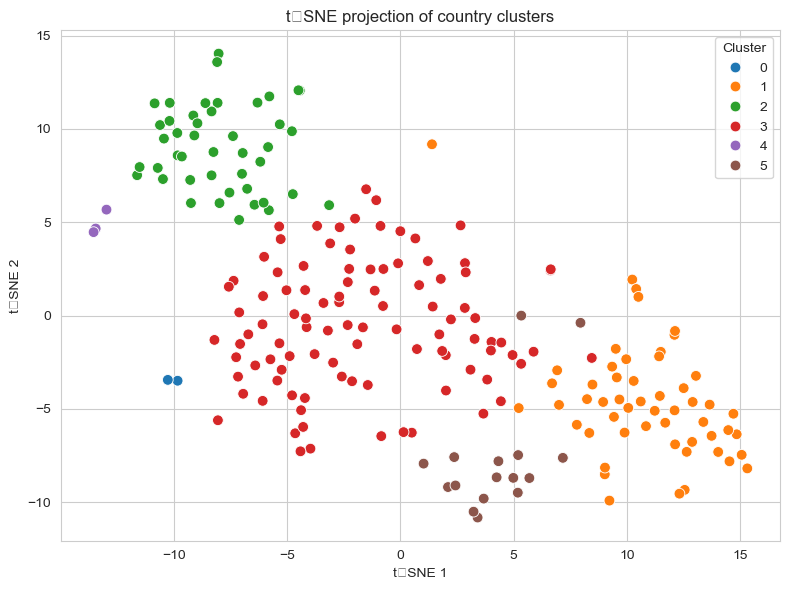

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, palette="tab10", s=60)
plt.title("t‑SNE projection of country clusters")
plt.xlabel("t‑SNE 1"); plt.ylabel("t‑SNE 2")
plt.legend(title="Cluster"); plt.tight_layout(); plt.show()


In [8]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_pca, labels)
print(f"Silhouette for k={best_k}: {score:.3f}")


Silhouette for k=6: 0.251


In [9]:
# import geopandas as gpd

export_df = pillar_scores.reset_index().rename(columns={"index": "iso3"})

# 2) (Optional) If you want human-readable cluster descriptions:
cluster_desc = {
    0: "Extreme GDP outlier",
    1: "Low across all pillars",
    2: "Demographic & governance leader",
    3: "Global average",
    4: "Balanced high performer",
    5: "Mid-income, weak governance"
}
export_df["cluster_desc"] = export_df["cluster"].map(cluster_desc)

# 3) Write to CSV
export_df.to_csv("./data/clean/country_clusters_k6.csv", index=False)

print(f"Wrote {len(export_df)} rows to {'./data/clean/country_clusters_k6.csv'}")

Wrote 216 rows to ./data/clean/country_clusters_k6.csv


In [ ]:
import geopandas as gpd

# Download the Natural Earth dataset manually from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
# and provide the path to the downloaded file below.
world = gpd.read_file("./data/naturalearth_lowres.shp")
world = world[["iso_a3", "name", "geometry"]].rename(columns={"iso_a3":"iso3"})

scores = pd.read_csv("./data/clean/country_clusters_k6.csv").set_index("iso3")

cluster_desc = {
    0: "Extreme GDP per capita outlier",
    1: "Low across all pillars",
    2: "Strong demographics & governance",
    3: "Global average",
    4: "Balanced high performers",
    5: "Mid‑income, weak governance"
}
scores["cluster_desc"] = scores["cluster"].map(cluster_desc)

gdf = world.merge(scores, left_on="iso3", right_index=True, how="left")

OUTFILE = DATA_DIR / "country_clusters_k6.geojson"
gdf.to_file(OUTFILE, driver="GeoJSON")
print("Wrote", OUTFILE)

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.